In [1]:
!pip install git+https://github.com/pe8sutd/eda4u &> /dev/null
!git clone https://github.com/pe8sutd/eda4u &> /dev/null
%load_ext plugin

Installing. Please wait... done!


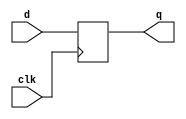

In [2]:
#DFF
%%print_verilog
module top_module (
    input clk,
    input d,
    output reg q );

    always @(posedge clk)
        q <= d;

endmodule

In [13]:
%%verilog

//////////////////////////////////////////////////////////
module tb; reg clk_tb, d_tb; wire q_tb;

  parameter CYCLE = 10;

  top_module top(.clk(clk_tb), .d(d_tb), .q(q_tb));

  task dinp(input i);
  begin
    @(negedge clk_tb);
      d_tb = i;
    end
  endtask

  initial begin
    $dumpfile("tb");
    $dumpvars();

    dinp(1);
    dinp(0);
    dinp(0);
    dinp(1);
    # 10 $finish;
  end

  initial clk_tb = 1;
  initial d_tb = 0;

  always begin
    #(CYCLE/10);
    clk_tb = 1;
    #(CYCLE/10);
    clk_tb = 0;
  end
//////////////////////////////////////////////////////////

endmodule

//////////////////////////////////////////////////////////
module top_module (
    input clk,
    input d,
    output reg q );

    always @(posedge clk)
        q <= d;

endmodule
//////////////////////////////////////////////////////////


VCD info: dumpfile tb.vcd opened for output.



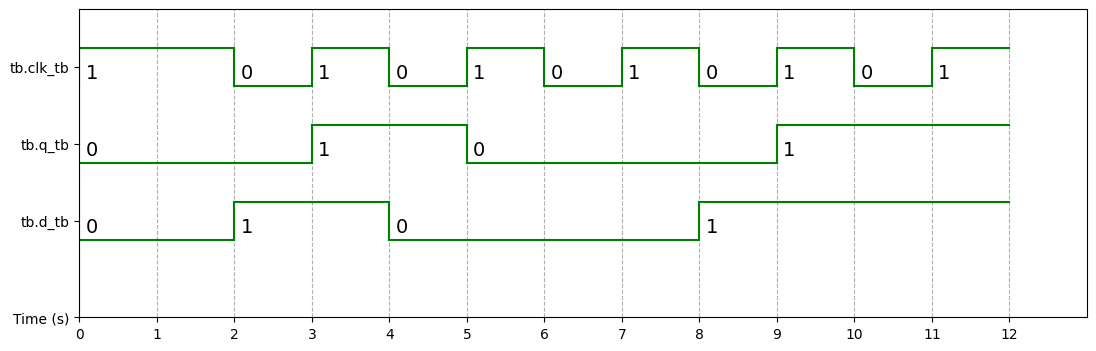

In [14]:
%%waveform tb.vcd
sign_list = ['tb.clk_tb', 'tb.q_tb','tb.d_tb']
time_begin = 0
time_end = 12
base = 'dec' # bin, dec, dec2, hex, octal